In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 as cv
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
ims = []

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        ims.append(os.path.join(dirname, filename))

# print(ims)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# CNN Model on original dataset

In [ ]:
normal_samples = []
pneumonia_samples = []

for im in ims:
    if "NORMAL" in im:
        normal_samples.append(im)
    elif "PNEUMONIA" in im:
        pneumonia_samples.append(im)

print("Normal samples:", len(normal_samples))
print("Pneuomonia samples:", len(pneumonia_samples))

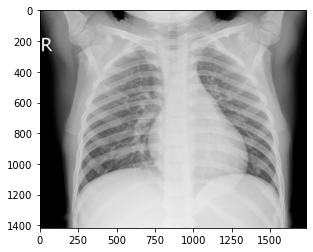

In [44]:
temp = cv.imread(normal_samples[0])
plt.imshow(temp)

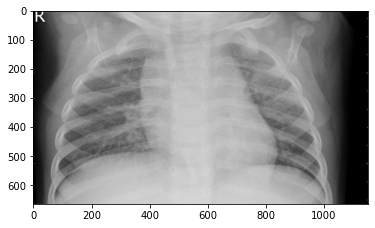

In [5]:
temp = cv.imread(pneumonia_samples[0])
plt.imshow(temp)

In [46]:
def preprocessImage(imgs_inp):
    preprocessed = []
    for im in imgs_inp:
        im = cv.imread(im)
        if type(im) == np.ndarray:
            im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
            im = cv.blur(im, (3,3))
            preprocessed.append(cv.resize(im, (32, 32)))
            
    return preprocessed

In [65]:
normalpre = preprocessImage(normal_samples)
pneumoniapre = preprocessImage(pneumonia_samples)

In [66]:
n_train = normalpre[:int((80/100)*len(normalpre))]
p_train = pneumoniapre[:int((80/100)*len(pneumoniapre))]
y_train = [0]*len(n_train) + [1]*len(p_train)

n_test = normalpre[int((80/100)*len(normalpre)):]
p_test = pneumoniapre[int((80/100)*len(pneumoniapre)):]
y_test = [0]*len(n_test) + [1]*len(p_test)

In [67]:
n_train, p_train, n_test, p_test = np.array(n_train)/255, np.array(p_train)/255, np.array(n_test)/255, np.array(p_test)/255

In [68]:
x_train = np.array(list(n_train) + list(p_train))
x_test = np.array(list(n_test) + list(p_test))

print(len(x_train), len(y_train), len(x_test), len(y_test))
# print(x_train)

9368 9368 2344 2344


In [69]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((9368, 32, 32, 1), (2344, 32, 32, 1), (9368,), (2344,))

In [70]:
from tensorflow import keras 
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
model = keras.Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape = (32, 32, 1)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(1024, activation="relu"),
    Dense(200, activation="relu"),
    Dense(2, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
293/293 [==============================] - 2s 4ms/step - loss: 0.2446 - accuracy: 0.8982
Epoch 2/20
293/293 [==============================] - 1s 3ms/step - loss: 0.1236 - accuracy: 0.9539
Epoch 3/20
293/293 [==============================] - 1s 3ms/step - loss: 0.0998 - accuracy: 0.9632
Epoch 4/20
293/293 [==============================] - 1s 3ms/step - loss: 0.0777 - accuracy: 0.9713
Epoch 5/20
293/293 [==============================] - 1s 3ms/step - loss: 0.0631 - accuracy: 0.9767
Epoch 6/20
293/293 [==============================] - 1s 3ms/step - loss: 0.0490 - accuracy: 0.9822
Epoch 7/20
293/293 [==============================] - 1s 3ms/step - loss: 0.0467 - accuracy: 0.9836
Epoch 8/20
293/293 [==============================] - 1s 3ms/step - loss: 0.0378 - accuracy: 0.9869
Epoch 9/20
293/293 [==============================] - 1s 5ms/step - loss: 0.0343 - accuracy: 0.9877
Epoch 10/20
293/293 [==============================] - 1s 4ms/step - loss: 0.0292 - accuracy: 0.9896

In [71]:
model.evaluate(x_test, y_test)

74/74 [==============================] - 0s 3ms/step - loss: 0.0104 - accuracy: 0.9966


[0.010409509763121605, 0.9965870380401611]

As seen above, the accuracy on the original dataset is approximately 99.66%.

# Deepfake Generation using DCGAN

In [2]:
import sys, os, glob, time, imageio 
import numpy as np, pandas as pd  
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image 
import torch 
import torchvision.utils as vutils 
import torchvision.transforms as transforms 
from keras import models, layers, optimizers 
from keras.models import Sequential 
from keras.preprocessing.image import array_to_img, img_to_array, load_img 
import tensorflow as tf 

In [3]:
# Root directory for dataset
path_root = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'
path_train= '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/'
path_test = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test/'
path_val  = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val/'

# Root paths for X-Ray images
XRay_normal     = glob.glob(path_root+'*/NORMAL/*.jpeg', recursive=True)
XRay_pneumonial = glob.glob(path_root+'*/PNEUMONIA/*.jpeg', recursive=True)

# Root paths for X-Ray training images
train_normal    = glob.glob(path_train+'NORMAL/*.jpeg', recursive=True)
train_pneumonial= glob.glob(path_train+'PNEUMONIA/*.jpeg', recursive=True)

# X-Ray testing images 
test_normal     = os.listdir(path_test+'NORMAL/')
test_pneumonial = os.listdir(path_test+'PNEUMONIA/')

In [4]:
print('The Chest X-Ray Images dataset contains {:04d} NORMAL and {:04d} PNEUMONIA images and {:03d} images in total'\
      .format(len(XRay_normal), 
              len(XRay_pneumonial),
              len(glob.glob(path_root+'*/*/*.jpeg')),))
print('The training dataset has {:04d} NORMAL, {:04d} PNEUMONIA and {:04d} images total'\
      .format(len(train_normal), 
              len(train_pneumonial), 
              len(glob.glob(path_train+'*/*.jpeg'))))
print('The testing dataset has {:03d} NORMAL and {:03d} PNEUMONIA and {:03d} images total'\
      .format(len(test_normal), 
              len(test_pneumonial), 
              len(glob.glob(path_test+'*/*.jpeg'))))
print('The validation dataset has {:01d} NORMAL and {:01d} PNEUMONIA and {:02d} images total'\
      .format(len(glob.glob(path_val+'NORMAL/*.jpeg')), 
              len(glob.glob(path_val+'PNEUMONIA/*.jpeg')), 
              len(glob.glob(path_val+'*/*.jpeg'))))

The Chest X-Ray Images dataset contains 1583 NORMAL and 4273 PNEUMONIA images and 5856 images in total
The training dataset has 1341 NORMAL, 3875 PNEUMONIA and 5216 images total
The testing dataset has 234 NORMAL and 390 PNEUMONIA and 624 images total
The validation dataset has 8 NORMAL and 8 PNEUMONIA and 16 images total


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  


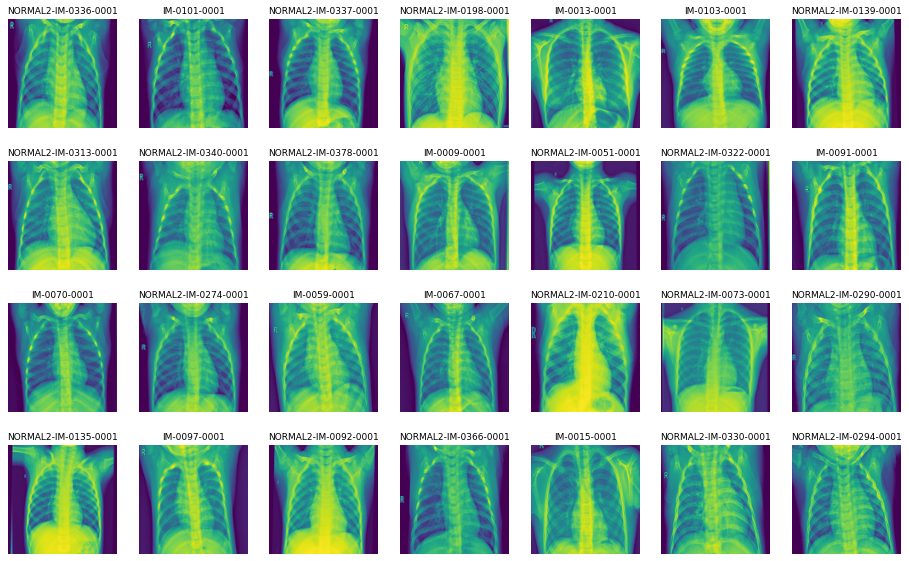

In [5]:
nrows, ncols = 4, 7
plt.figure(figsize=(16,10))
for idx, name in enumerate(test_normal[:nrows*ncols]):
    plt.subplot(nrows, ncols, idx+1)
    img = Image.open(path_test+'NORMAL/'+name) 
    img = img.resize(size=(128, 128), resample=Image.ANTIALIAS, box=None)
    plt.imshow(img)
    plt.title(name[:-5], fontsize=9)
    plt.axis('off')
plt.show()

In [6]:
def get_data(data_path, dim=(128, 128), rand_shuffle=True): 
    start = time.time() 
    imgs_data = []         
    sample_size = len(data_path)
    for idx, im_path in enumerate(data_path): 
        if idx%(sample_size//10)==0:
            print('Processing index {:05d} of {:05d} ==> {:03d}%'\
                  .format(idx, sample_size, round(100*idx/sample_size))) 
        img = img_to_array(load_img(im_path, target_size = dim)) 
        imgs_data.append(img) 
        
    # to float 
    imgs_data = np.array(imgs_data).astype('float32') 
    # scale to [0,1] (note the . after 255 - float)
    imgs_data = imgs_data/255. 
    
    # shuffle the data 
    if rand_shuffle: 
        idx = np.arange(imgs_data.shape[0])
        np.random.shuffle(idx) 
        imgs_data = imgs_data[idx,:,:,:] 
    return imgs_data 

In [7]:
print('Starting for NORMAL X-Ray images ...')
X_normal = get_data(XRay_normal)
print()
print('Starting for PNEUMONIA X-Ray images ...')
X_pneumonial = get_data(XRay_pneumonial) 

Starting for NORMAL X-Ray images ...
Processing index 00000 of 01583 ==> 000%
Processing index 00158 of 01583 ==> 010%
Processing index 00316 of 01583 ==> 020%
Processing index 00474 of 01583 ==> 030%
Processing index 00632 of 01583 ==> 040%
Processing index 00790 of 01583 ==> 050%
Processing index 00948 of 01583 ==> 060%
Processing index 01106 of 01583 ==> 070%
Processing index 01264 of 01583 ==> 080%
Processing index 01422 of 01583 ==> 090%
Processing index 01580 of 01583 ==> 100%

Starting for PNEUMONIA X-Ray images ...
Processing index 00000 of 04273 ==> 000%
Processing index 00427 of 04273 ==> 010%
Processing index 00854 of 04273 ==> 020%
Processing index 01281 of 04273 ==> 030%
Processing index 01708 of 04273 ==> 040%
Processing index 02135 of 04273 ==> 050%
Processing index 02562 of 04273 ==> 060%
Processing index 02989 of 04273 ==> 070%
Processing index 03416 of 04273 ==> 080%
Processing index 03843 of 04273 ==> 090%
Processing index 04270 of 04273 ==> 100%


In [8]:
def _time(start, end): 
    # if in seconds 
    if (end-start)<60: 
        wall_time = f'{round((end-start),2)}sec'
    # if in minute(s)  
    elif (end-start)>=3600: 
        wall_time = f'{int((end-start)/3600)}h {int(((end-start)%3600)/60)}min {round((end-start)%60,2)}sec'
    # if in houre(s)  
    else: 
        wall_time = f'{int((end-start)/60)}min {round((end-start)%60,2)}sec'
    return wall_time 

In [9]:
def define_grid(data_images, nrows=4, ncols=5, plot_grid=True):
    start = time.time() 
    ngpu = 1 
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    # Rearange the shape of the data 
    data_transp = [np.transpose(data_images[i,:,:]) for i in range(data_images[:nrows*ncols].shape[0])]
    # From to torch type for the grid 
    data_transp = torch.Tensor(data_transp)
    print(f'The shape is reordered from {data_images.shape[1:]} to {data_transp.shape[1:]} in {_time(start, time.time())}')
    
    # Make the grid 
    grid_images = np.transpose(
        vutils.make_grid(
            data_transp.to(device)[:nrows*ncols], 
            nrow=nrows,
            padding=2,
            normalize=True,
            scale_each=True,
            pad_value=1,
        ).cpu(), axes=(2,1,0))
        
    # Show the output grid 
    if plot_grid:
        plt.figure(figsize=(12,12)) 
        plt.axis("off") 
        plt.title(f'Grid of {nrows*ncols} real images', fontsize=27)
        plt.imshow(grid_images)
        
    return grid_images

grid_X_normal = define_grid(X_normal, plot_grid=False)
grid_X_pneumonial = define_grid(X_pneumonial, plot_grid=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:207.)
  


The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.19sec
The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.08sec


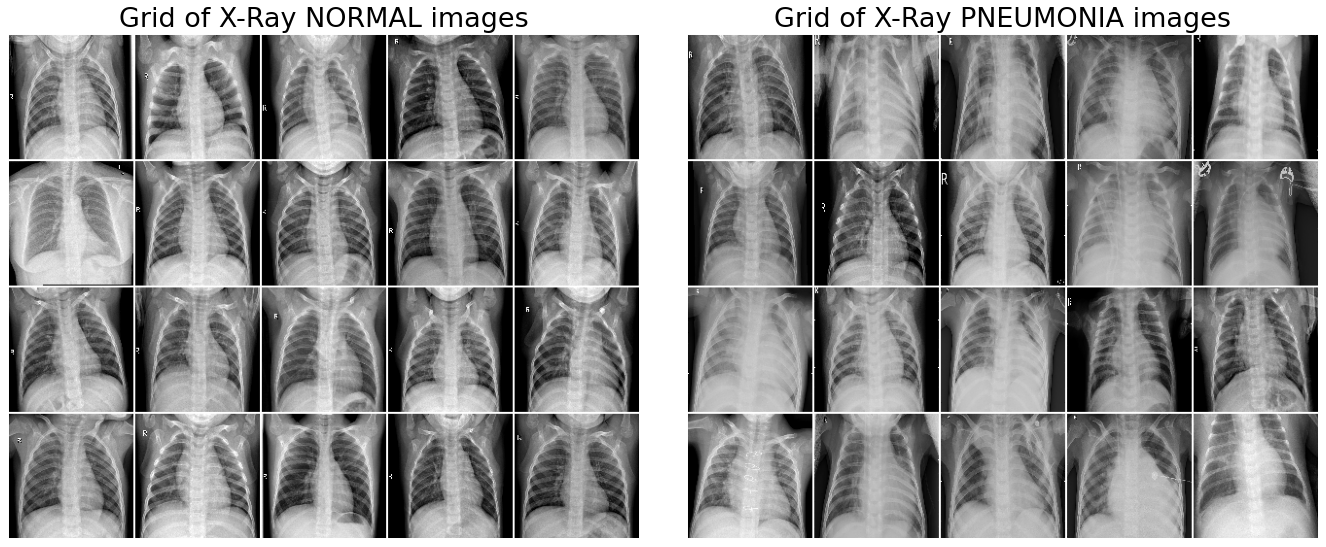

In [10]:
fig, (ax1, ax2)= plt.subplots(nrows = 1, ncols = 2, figsize = (19, 8))
ax1.imshow(grid_X_normal); ax1.axis('off')
ax1.set_title(label = 'Grid of X-Ray NORMAL images', fontsize = 27)
ax2.imshow(grid_X_pneumonial); ax2.axis('off')
ax2.set_title(label = 'Grid of X-Ray PNEUMONIA images', fontsize = 27)
plt.tight_layout(pad = 1.08, h_pad = None, w_pad = None, rect = [0, 0.03, 1, 0.95])

In [11]:
n_epoch = 200
batch_size = 128 
latent_dim = 100 
cols, rows = 128, 128 
channels = 3 
dim = cols, rows 
in_shape = (cols, rows, channels) 
lr = 0.0002
beta1 = 0.5
ngpu = 1 
nrows, ncols = 3, 4

In [12]:
def define_discriminator(in_shape = (128,128,3)): 
    model = models.Sequential() 
    # normal 
    model.add(layers.Conv2D(128, (5,5), padding = 'same', input_shape = in_shape)) 
    model.add(layers.LeakyReLU(alpha = 0.2)) 
    # downsample to 64x64 
    model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same')) 
    model.add(layers.LeakyReLU(alpha = 0.2)) 
    # downsample to 32x32 
    model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same')) 
    model.add(layers.LeakyReLU(alpha = 0.2)) 
    # downsample to 16x16 
    model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same')) 
    model.add(layers.LeakyReLU(alpha = 0.2)) 
    # downsample to 8x8 
    model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same')) 
    model.add(layers.LeakyReLU(alpha = 0.2)) 
    # classifier 
    model.add(layers.Flatten()) 
    model.add(layers.Dropout(0.4)) 
    model.add(layers.Dense(1, activation = 'sigmoid')) 
    # compile model 
    opt = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5) 
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy']) 
    return model

In [13]:
def define_generator(latent_dim):
    model = models.Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128*8*8
    model.add(layers.Dense(n_nodes, input_dim = latent_dim))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
    model.add(layers.LeakyReLU(alpha = 0.2))
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
    model.add(layers.LeakyReLU(alpha = 0.2))
    # upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
    model.add(layers.LeakyReLU(alpha = 0.2))
    # upsample to 128x128
    model.add(layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
    model.add(layers.LeakyReLU(alpha = 0.2))
    # output layer 128x128x3
    model.add(layers.Conv2D(3, (5,5), activation = 'tanh', padding = 'same'))
    return model 

def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim*n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input 

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [14]:
def define_gan(g_model, d_model): 
    d_model.trainable = False 
    model = models.Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images 
def show_generated(generated, epoch, nrows=4, ncols=5):
    plt.figure(figsize=(10,10)) 
    for idx in range(nrows*ncols): 
        plt.subplot(nrows, ncols, idx+1) 
        plt.imshow(generated[idx]) 
        plt.axis('off') 
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1)) 
    plt.show() 

# evaluate the discriminator and plot generated images 
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples 
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples 
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples 
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance 
    print('> Accuracy at epoch %d [real: %.0f%%, fake: %.0f%%]'%(epoch+1, acc_real*100, acc_fake*100))
    show_generated(x_fake, epoch)
    
def plot_loss(loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training", fontsize=20) 
    plt.plot(loss[0], label="D_real") 
    plt.plot(loss[1], label="D_fake") 
    plt.plot(loss[2], label="G") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

In [15]:
def train(g_model, d_model, gan_model, dataset, latent_dim = 100, n_epochs = 100, n_batch = 128):
    start = time.time() 
    bat_per_epo = int(dataset.shape[0]/n_batch) 
    half_batch = int(n_batch/2) 
    loss1, loss2, loss3 = [], [], [] 
    fake_liste = [] 
    print('Training Start...')
    for i in range(n_epochs):
        start1 = time.time()
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            loss1.append(d_loss1); loss2.append(d_loss2); loss3.append(g_loss) 
        
        print('Epoch: {:03d}/{:03d}, Loss: [D_real = {:2.3f}, D_fake = {:2.3f}, G = {:2.3f}], time: {:s}'\
              .format(i+1,n_epochs,d_loss1,d_loss2,g_loss, _time(start1,time.time())))
        # evaluate the model performance 
        if (i+1)%(n_epochs//10) == 0: 
            # Save and show generated images 
            summarize_performance(i, g_model, d_model, dataset, latent_dim) 
        
    print('Total time for training {} epochs is {} sec'.format(n_epochs, _time(start, time.time())))
    
    # Show loss curves 
    loss = (loss1, loss2, loss3) 
    plot_loss(loss) 

In [16]:
discriminator = define_discriminator() 
generator = define_generator(latent_dim) 
gan = define_gan(generator, discriminator)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training Start...
Epoch: 001/200, Loss: [D_real = 0.261, D_fake = 0.177, G = 2.982], time: 23.02sec
Epoch: 002/200, Loss: [D_real = 0.229, D_fake = 0.158, G = 3.870], time: 21.91sec
Epoch: 003/200, Loss: [D_real = 0.343, D_fake = 0.212, G = 3.537], time: 21.26sec
Epoch: 004/200, Loss: [D_real = 0.302, D_fake = 0.214, G = 3.288], time: 21.51sec
Epoch: 005/200, Loss: [D_real = 0.385, D_fake = 0.155, G = 3.420], time: 22.36sec
Epoch: 006/200, Loss: [D_real = 0.722, D_fake = 0.597, G = 2.801], time: 21.89sec
Epoch: 007/200, Loss: [D_real = 0.220, D_fake = 0.182, G = 3.659], time: 21.56sec
Epoch: 008/200, Loss: [D_real = 0.240, D_fake = 0.166, G = 3.711], time: 21.94sec
Epoch: 009/200, Loss: [D_real = 0.878, D_fake = 0.780, G = 3.500], time: 21.69sec
Epoch: 010/200, Loss: [D_real = 0.228, D_fake = 0.145, G = 3.681], time: 21.85sec
Epoch: 011/200, Loss: [D_real = 0.193, D_fake = 0.234, G = 4.182], time: 21.92sec
Epoch: 012/200, Loss: [D_real = 0.140, D_fake = 0.136, G = 4.157], time: 21.76se

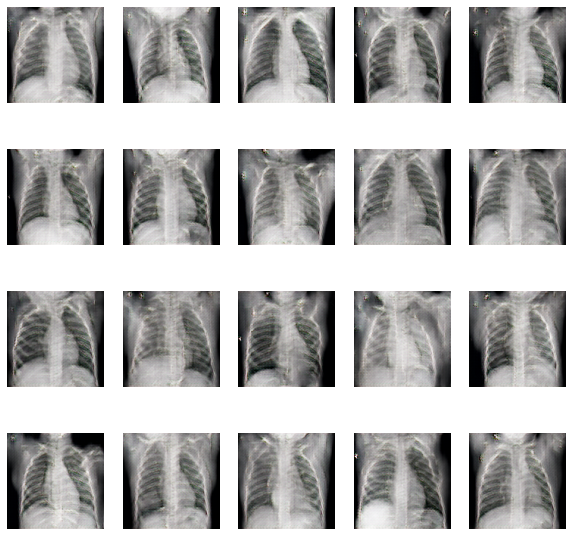

Epoch: 021/200, Loss: [D_real = 0.179, D_fake = 0.241, G = 5.169], time: 21.62sec
Epoch: 022/200, Loss: [D_real = 0.143, D_fake = 0.276, G = 5.047], time: 21.69sec
Epoch: 023/200, Loss: [D_real = 0.181, D_fake = 0.166, G = 4.027], time: 21.69sec
Epoch: 024/200, Loss: [D_real = 0.158, D_fake = 0.123, G = 3.701], time: 21.78sec
Epoch: 025/200, Loss: [D_real = 0.136, D_fake = 0.133, G = 3.893], time: 21.89sec
Epoch: 026/200, Loss: [D_real = 0.255, D_fake = 0.205, G = 4.743], time: 21.72sec
Epoch: 027/200, Loss: [D_real = 0.303, D_fake = 0.206, G = 4.466], time: 21.66sec
Epoch: 028/200, Loss: [D_real = 0.251, D_fake = 0.190, G = 3.970], time: 22.07sec
Epoch: 029/200, Loss: [D_real = 0.086, D_fake = 0.127, G = 4.338], time: 21.67sec
Epoch: 030/200, Loss: [D_real = 0.105, D_fake = 0.140, G = 4.410], time: 21.59sec
Epoch: 031/200, Loss: [D_real = 0.147, D_fake = 0.152, G = 4.646], time: 21.75sec
Epoch: 032/200, Loss: [D_real = 0.155, D_fake = 0.176, G = 4.627], time: 22.38sec
Epoch: 033/200, 

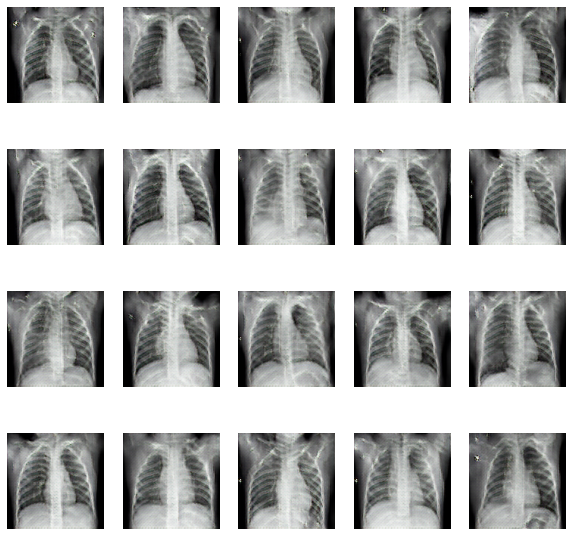

Epoch: 041/200, Loss: [D_real = 0.099, D_fake = 0.134, G = 4.029], time: 21.91sec
Epoch: 042/200, Loss: [D_real = 0.210, D_fake = 0.129, G = 4.234], time: 21.72sec
Epoch: 043/200, Loss: [D_real = 0.136, D_fake = 0.275, G = 5.079], time: 21.57sec
Epoch: 044/200, Loss: [D_real = 0.296, D_fake = 0.196, G = 4.160], time: 21.73sec
Epoch: 045/200, Loss: [D_real = 0.191, D_fake = 0.291, G = 4.383], time: 21.98sec
Epoch: 046/200, Loss: [D_real = 0.122, D_fake = 0.190, G = 5.015], time: 22.02sec
Epoch: 047/200, Loss: [D_real = 0.167, D_fake = 0.175, G = 4.313], time: 21.96sec
Epoch: 048/200, Loss: [D_real = 0.078, D_fake = 0.109, G = 4.707], time: 21.49sec
Epoch: 049/200, Loss: [D_real = 0.133, D_fake = 0.091, G = 4.590], time: 21.75sec
Epoch: 050/200, Loss: [D_real = 0.224, D_fake = 0.110, G = 3.876], time: 22.02sec
Epoch: 051/200, Loss: [D_real = 0.965, D_fake = 0.461, G = 4.481], time: 22.13sec
Epoch: 052/200, Loss: [D_real = 0.061, D_fake = 0.232, G = 5.079], time: 21.72sec
Epoch: 053/200, 

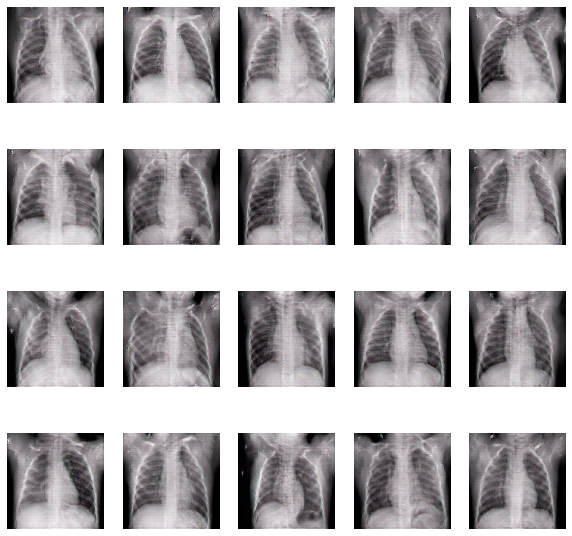

Epoch: 061/200, Loss: [D_real = 0.168, D_fake = 0.127, G = 4.270], time: 21.78sec
Epoch: 062/200, Loss: [D_real = 0.812, D_fake = 0.292, G = 3.984], time: 21.67sec
Epoch: 063/200, Loss: [D_real = 0.093, D_fake = 0.090, G = 4.522], time: 22.06sec
Epoch: 064/200, Loss: [D_real = 0.824, D_fake = 0.162, G = 3.072], time: 21.76sec
Epoch: 065/200, Loss: [D_real = 0.184, D_fake = 0.101, G = 3.916], time: 21.7sec
Epoch: 066/200, Loss: [D_real = 0.334, D_fake = 0.173, G = 3.164], time: 22.03sec
Epoch: 067/200, Loss: [D_real = 0.169, D_fake = 0.062, G = 3.930], time: 21.67sec
Epoch: 068/200, Loss: [D_real = 0.304, D_fake = 0.075, G = 3.865], time: 21.74sec
Epoch: 069/200, Loss: [D_real = 0.130, D_fake = 0.107, G = 4.353], time: 21.73sec
Epoch: 070/200, Loss: [D_real = 0.136, D_fake = 0.231, G = 5.187], time: 22.01sec
Epoch: 071/200, Loss: [D_real = 0.139, D_fake = 0.107, G = 4.284], time: 21.76sec
Epoch: 072/200, Loss: [D_real = 0.256, D_fake = 0.111, G = 4.479], time: 22.12sec
Epoch: 073/200, L

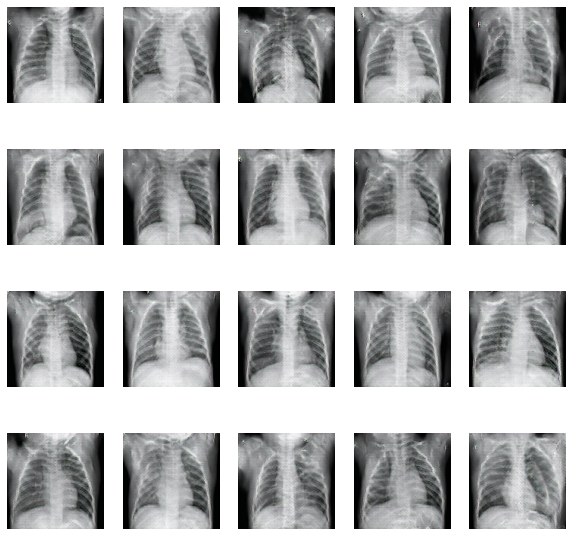

Epoch: 081/200, Loss: [D_real = 0.080, D_fake = 0.113, G = 4.902], time: 21.96sec
Epoch: 082/200, Loss: [D_real = 0.097, D_fake = 0.108, G = 4.350], time: 21.62sec
Epoch: 083/200, Loss: [D_real = 0.065, D_fake = 0.022, G = 4.931], time: 21.64sec
Epoch: 084/200, Loss: [D_real = 0.593, D_fake = 0.676, G = 4.237], time: 21.63sec
Epoch: 085/200, Loss: [D_real = 0.069, D_fake = 0.144, G = 5.010], time: 21.76sec
Epoch: 086/200, Loss: [D_real = 0.193, D_fake = 0.087, G = 4.156], time: 21.8sec
Epoch: 087/200, Loss: [D_real = 0.209, D_fake = 0.194, G = 3.946], time: 21.79sec
Epoch: 088/200, Loss: [D_real = 0.169, D_fake = 0.355, G = 5.179], time: 21.73sec
Epoch: 089/200, Loss: [D_real = 0.109, D_fake = 0.212, G = 5.047], time: 21.71sec
Epoch: 090/200, Loss: [D_real = 0.194, D_fake = 0.164, G = 4.860], time: 21.85sec
Epoch: 091/200, Loss: [D_real = 0.085, D_fake = 0.084, G = 4.086], time: 21.72sec
Epoch: 092/200, Loss: [D_real = 0.057, D_fake = 0.113, G = 4.969], time: 22.01sec
Epoch: 093/200, L

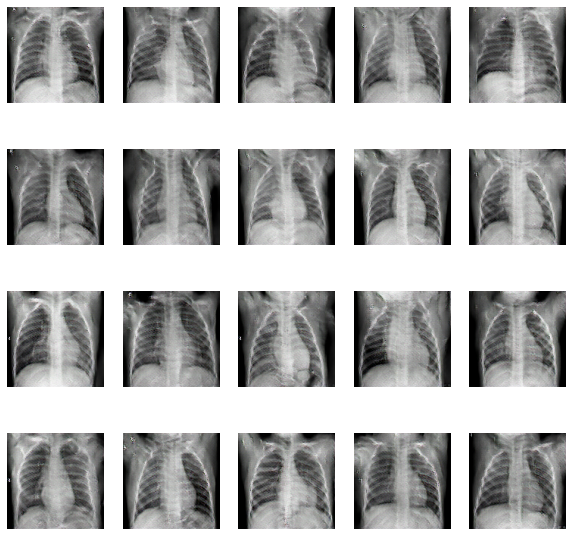

Epoch: 101/200, Loss: [D_real = 0.062, D_fake = 0.206, G = 5.791], time: 21.98sec
Epoch: 102/200, Loss: [D_real = 0.125, D_fake = 0.300, G = 6.427], time: 21.64sec
Epoch: 103/200, Loss: [D_real = 0.158, D_fake = 0.122, G = 5.495], time: 22.11sec
Epoch: 104/200, Loss: [D_real = 0.112, D_fake = 0.068, G = 4.546], time: 21.76sec
Epoch: 105/200, Loss: [D_real = 0.066, D_fake = 0.270, G = 6.790], time: 22.06sec
Epoch: 106/200, Loss: [D_real = 0.091, D_fake = 0.057, G = 4.560], time: 21.59sec
Epoch: 107/200, Loss: [D_real = 0.089, D_fake = 0.043, G = 4.819], time: 21.61sec
Epoch: 108/200, Loss: [D_real = 0.056, D_fake = 0.127, G = 5.026], time: 21.92sec
Epoch: 109/200, Loss: [D_real = 0.178, D_fake = 0.272, G = 3.843], time: 21.68sec
Epoch: 110/200, Loss: [D_real = 0.091, D_fake = 0.255, G = 5.615], time: 21.82sec
Epoch: 111/200, Loss: [D_real = 0.122, D_fake = 0.122, G = 4.275], time: 21.84sec
Epoch: 112/200, Loss: [D_real = 0.100, D_fake = 0.180, G = 5.019], time: 21.85sec
Epoch: 113/200, 

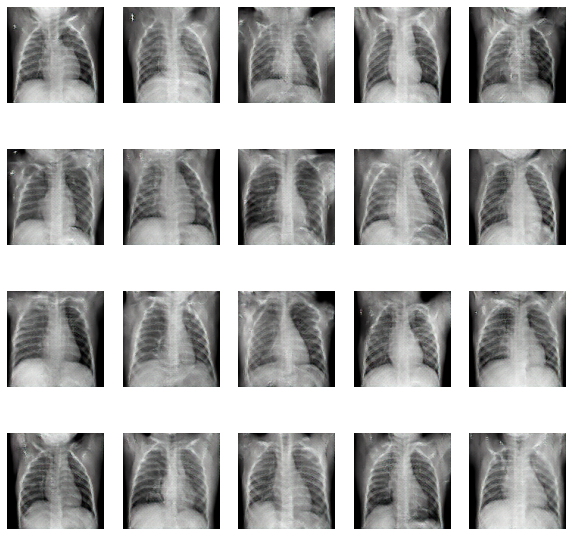

Epoch: 121/200, Loss: [D_real = 0.153, D_fake = 0.104, G = 4.816], time: 21.69sec
Epoch: 122/200, Loss: [D_real = 0.060, D_fake = 0.117, G = 6.667], time: 21.77sec
Epoch: 123/200, Loss: [D_real = 0.042, D_fake = 0.136, G = 5.419], time: 21.79sec
Epoch: 124/200, Loss: [D_real = 0.079, D_fake = 0.266, G = 5.975], time: 21.73sec
Epoch: 125/200, Loss: [D_real = 0.061, D_fake = 0.218, G = 5.864], time: 21.68sec
Epoch: 126/200, Loss: [D_real = 0.817, D_fake = 0.245, G = 3.185], time: 21.74sec
Epoch: 127/200, Loss: [D_real = 0.473, D_fake = 0.196, G = 3.237], time: 21.71sec
Epoch: 128/200, Loss: [D_real = 0.098, D_fake = 0.237, G = 4.490], time: 21.68sec
Epoch: 129/200, Loss: [D_real = 0.201, D_fake = 0.095, G = 4.469], time: 21.89sec
Epoch: 130/200, Loss: [D_real = 0.106, D_fake = 0.130, G = 4.117], time: 21.62sec
Epoch: 131/200, Loss: [D_real = 0.320, D_fake = 0.078, G = 4.160], time: 21.69sec
Epoch: 132/200, Loss: [D_real = 0.254, D_fake = 0.063, G = 3.754], time: 21.7sec
Epoch: 133/200, L

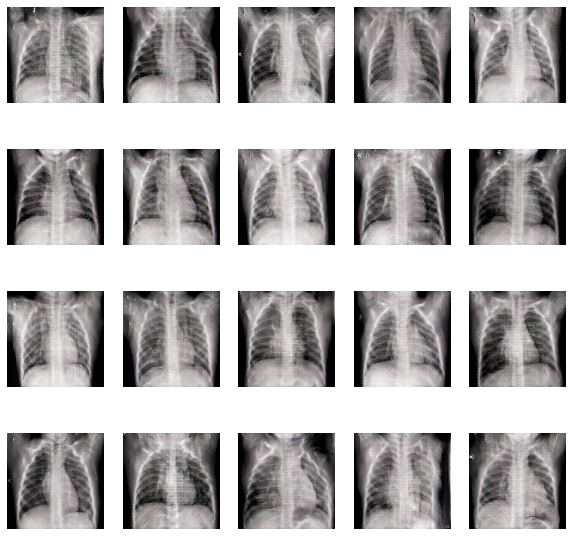

Epoch: 141/200, Loss: [D_real = 0.082, D_fake = 0.036, G = 5.130], time: 21.68sec
Epoch: 142/200, Loss: [D_real = 0.066, D_fake = 0.067, G = 4.151], time: 22.07sec
Epoch: 143/200, Loss: [D_real = 0.182, D_fake = 0.118, G = 4.076], time: 22.08sec
Epoch: 144/200, Loss: [D_real = 0.169, D_fake = 0.283, G = 4.874], time: 21.72sec
Epoch: 145/200, Loss: [D_real = 0.069, D_fake = 0.167, G = 5.635], time: 21.81sec
Epoch: 146/200, Loss: [D_real = 0.294, D_fake = 0.204, G = 4.635], time: 21.85sec
Epoch: 147/200, Loss: [D_real = 0.151, D_fake = 0.061, G = 4.468], time: 21.56sec
Epoch: 148/200, Loss: [D_real = 0.088, D_fake = 0.099, G = 4.917], time: 21.69sec
Epoch: 149/200, Loss: [D_real = 0.213, D_fake = 0.051, G = 3.918], time: 21.53sec
Epoch: 150/200, Loss: [D_real = 0.083, D_fake = 0.083, G = 4.674], time: 22.24sec
Epoch: 151/200, Loss: [D_real = 0.085, D_fake = 0.033, G = 4.391], time: 22.02sec
Epoch: 152/200, Loss: [D_real = 0.174, D_fake = 0.269, G = 4.916], time: 21.78sec
Epoch: 153/200, 

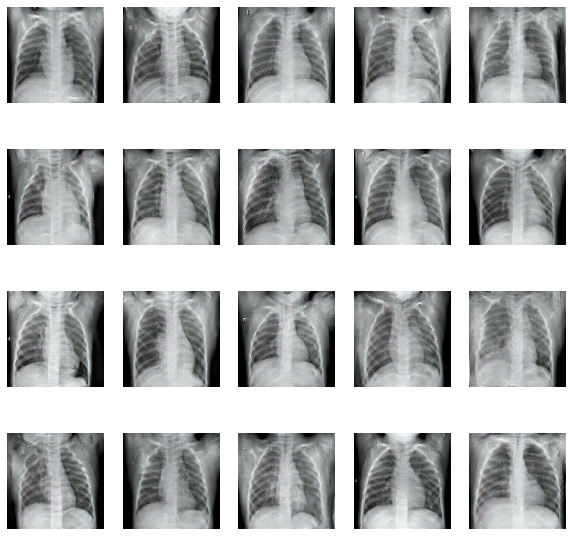

Epoch: 161/200, Loss: [D_real = 0.058, D_fake = 0.104, G = 4.224], time: 21.78sec
Epoch: 162/200, Loss: [D_real = 0.159, D_fake = 0.137, G = 5.223], time: 21.91sec
Epoch: 163/200, Loss: [D_real = 0.073, D_fake = 0.121, G = 5.634], time: 21.71sec
Epoch: 164/200, Loss: [D_real = 0.075, D_fake = 0.415, G = 5.290], time: 21.7sec
Epoch: 165/200, Loss: [D_real = 0.169, D_fake = 0.083, G = 5.085], time: 21.75sec
Epoch: 166/200, Loss: [D_real = 0.034, D_fake = 0.204, G = 6.189], time: 21.71sec
Epoch: 167/200, Loss: [D_real = 0.092, D_fake = 0.177, G = 5.232], time: 22.03sec
Epoch: 168/200, Loss: [D_real = 0.264, D_fake = 0.131, G = 4.127], time: 21.77sec
Epoch: 169/200, Loss: [D_real = 0.152, D_fake = 0.113, G = 4.611], time: 21.74sec
Epoch: 170/200, Loss: [D_real = 0.153, D_fake = 0.138, G = 4.498], time: 21.74sec
Epoch: 171/200, Loss: [D_real = 0.099, D_fake = 0.065, G = 3.872], time: 21.71sec
Epoch: 172/200, Loss: [D_real = 0.093, D_fake = 0.095, G = 5.010], time: 21.97sec
Epoch: 173/200, L

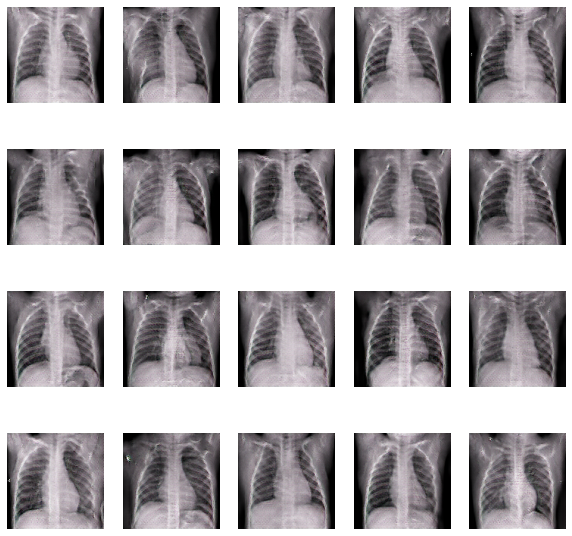

Epoch: 181/200, Loss: [D_real = 0.108, D_fake = 0.117, G = 4.633], time: 21.97sec
Epoch: 182/200, Loss: [D_real = 0.034, D_fake = 0.053, G = 4.950], time: 21.73sec
Epoch: 183/200, Loss: [D_real = 0.097, D_fake = 0.205, G = 5.439], time: 22.42sec
Epoch: 184/200, Loss: [D_real = 0.050, D_fake = 0.044, G = 4.637], time: 21.99sec
Epoch: 185/200, Loss: [D_real = 0.156, D_fake = 0.041, G = 4.875], time: 22.42sec
Epoch: 186/200, Loss: [D_real = 0.070, D_fake = 0.045, G = 5.375], time: 21.75sec
Epoch: 187/200, Loss: [D_real = 0.064, D_fake = 0.249, G = 7.319], time: 21.88sec
Epoch: 188/200, Loss: [D_real = 0.074, D_fake = 0.103, G = 5.076], time: 22.0sec
Epoch: 189/200, Loss: [D_real = 0.062, D_fake = 0.042, G = 5.400], time: 21.75sec
Epoch: 190/200, Loss: [D_real = 0.026, D_fake = 0.127, G = 7.020], time: 21.73sec
Epoch: 191/200, Loss: [D_real = 0.019, D_fake = 0.172, G = 5.823], time: 21.66sec
Epoch: 192/200, Loss: [D_real = 0.027, D_fake = 0.083, G = 6.206], time: 21.68sec
Epoch: 193/200, L

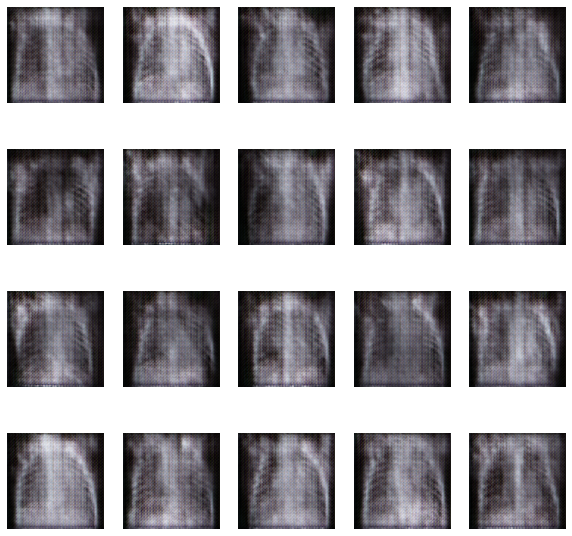

Total time for training 200 epochs is 1h 12min 57.59sec sec


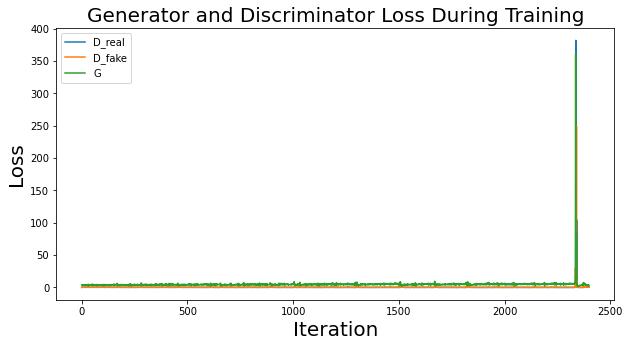

In [19]:
train(generator, discriminator, gan, X_normal, latent_dim, n_epochs = n_epoch, n_batch = batch_size)

In [14]:
model.save('cnn_model.h5') 

Generating and saving deepfakes using trained generator from dcgan

In [20]:
def save_fake_samples(g_model, latent_dim, n_samples=500):
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    for i in range(len(x_fake)):
        plt.axis('off')
        plt.imshow(x_fake[i])
        plt.savefig('/kaggle/working/FakeSamples/image{:04d}.png'.format(i+1))
        

In [ ]:
os.makedirs('/kaggle/working/FakeSamples')
save_fake_samples(generator, latent_dim)

# Running the model on Deepfakes

In [31]:
df_ims_ = []
for dirname, _, filenames in os.walk('/kaggle/working/FakeSamples'):
    df_ims_.append(filenames)
#     print(dirname, _, filenames)

df_ims = df_ims_[0]
# /kaggle/input/chest-ct-deepfakes/image0001.png
df_ims = ['/kaggle/working/FakeSamples/'+i for i in df_ims]


'/kaggle/working/FakeSamples/image0379.png'

In [33]:
temp = cv.imread(df_ims[0])


<class 'numpy.ndarray'>


In [52]:
def preprocessDeepFakes(imgs_inp):
    preprocessed = []
    for im in imgs_inp:
        im = cv.imread(im)
        if type(im) == np.ndarray:
            im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
            preprocessed.append(cv.resize(im, (32, 32)))
            
    return preprocessed

In [73]:
deepfakespre = preprocessDeepFakes(df_ims)
deepfakespre = np.array(deepfakespre)/255
deepfakes = deepfakespre.reshape((deepfakespre.shape[0], deepfakespre.shape[1], deepfakespre.shape[2], 1))
y_fake = np.random.randint(low=0, high=2, size=(500, 1))
deepfakes.shape, y_fake.shape

((500, 32, 32, 1), (500, 1))

In [74]:
model.evaluate(deepfakes, y_fake)

16/16 [==============================] - 0s 3ms/step - loss: 7.2324 - accuracy: 0.5000


[7.232410907745361, 0.5]

**As seen above, the accuracy of the model significantly decreases on a deepfakes dataset, to only 50%**